# Hacettepe University Department of Computer Enginnering
####                                                                             Fall 2019
####                                                BBM 409 - Machine Learning Laboratuvary
####                                                                          Assignment 1

### Name: Mert 
### Surname: Çökelek
### ID: 21727082
### Date: 29.10.2019


# REPORT
## PART I - Theory Questions

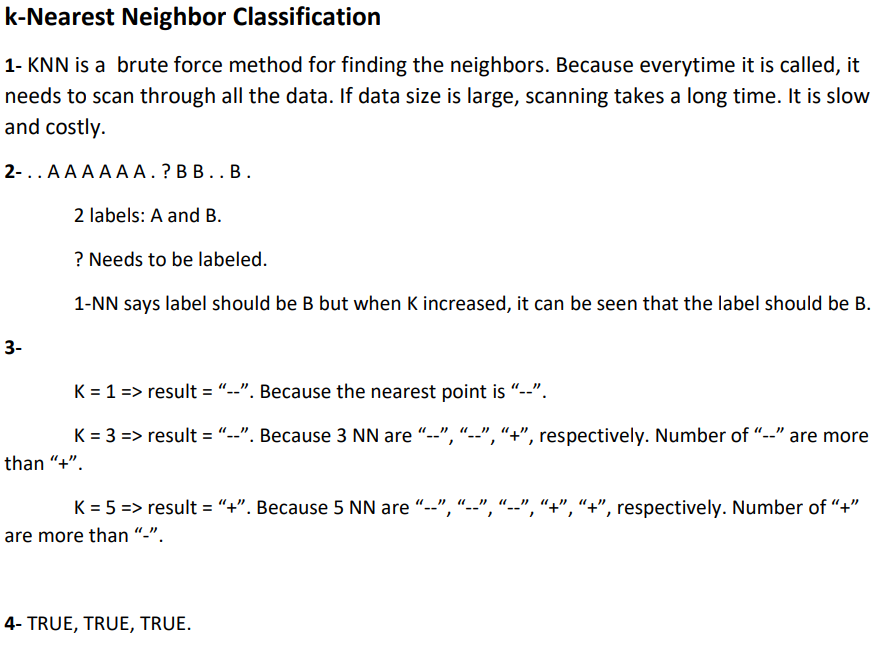
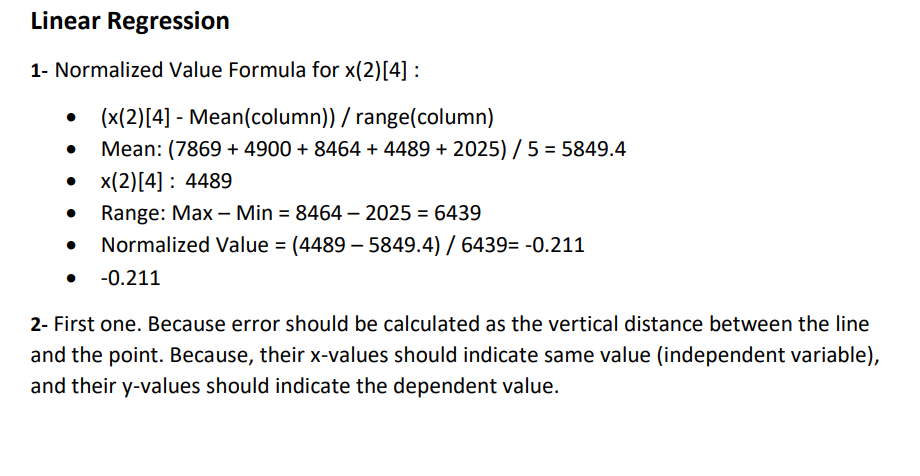
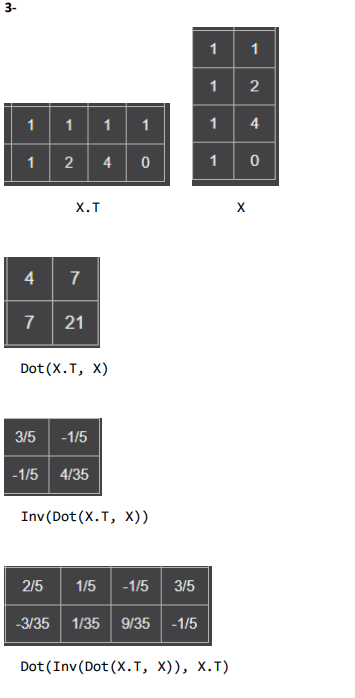
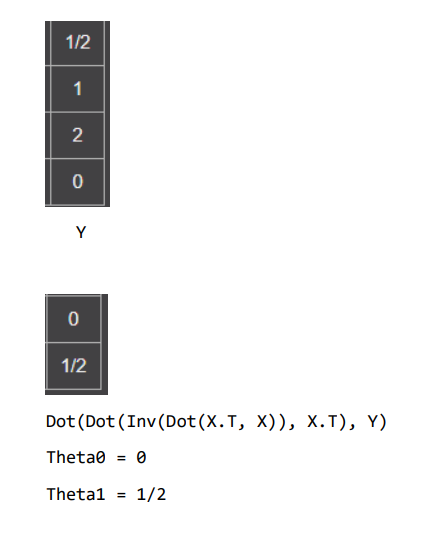

### 4- Feature scaling speeds up gradient descent. On multivariable regression, some features are on very larger values than others. 
### With feature scaling, those larger values are arranged in a small range like the others, so that gradient descent requires less iterations to converge.

## PART II

## 1. What is the main problem of this assignment?
#### In this assignment the main topics covered are:

-KNN algorithm

-Similarity Functions

-Collaborative Filtering (User Based)

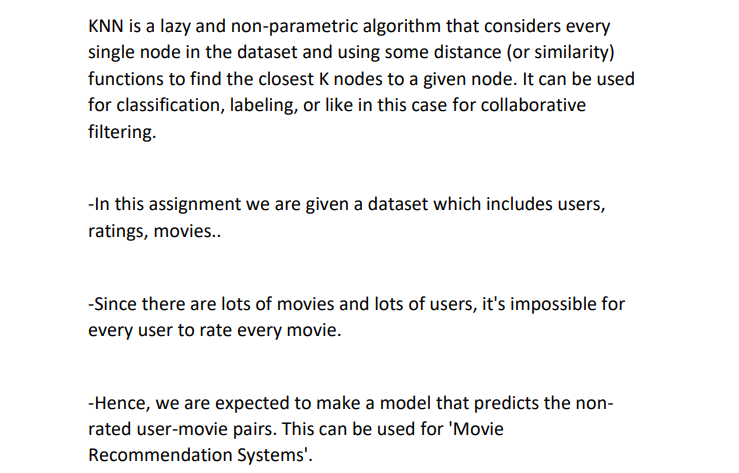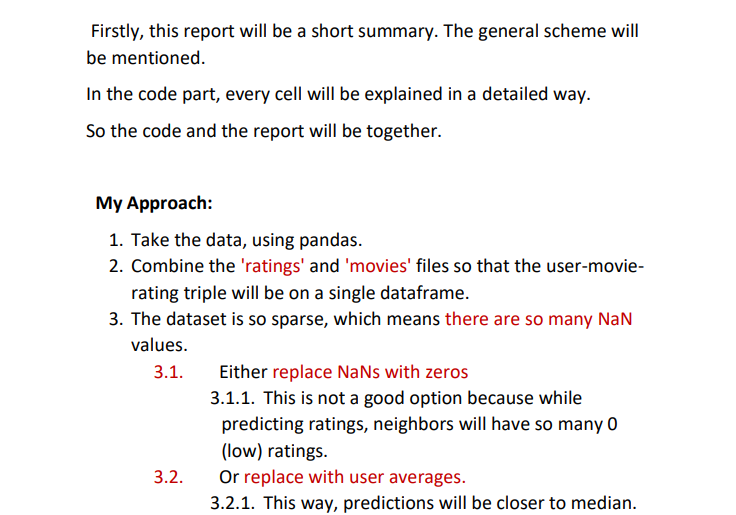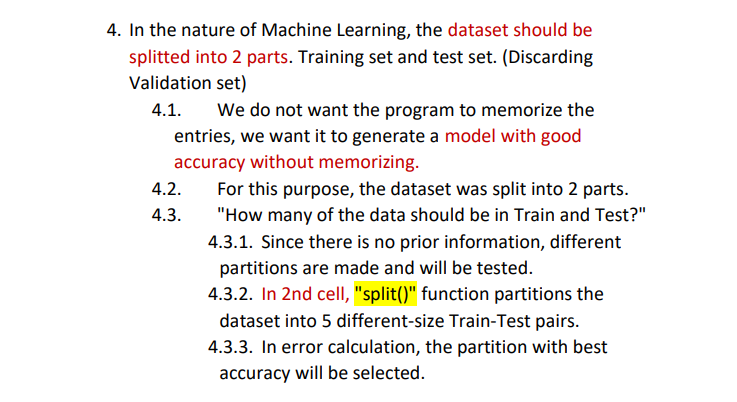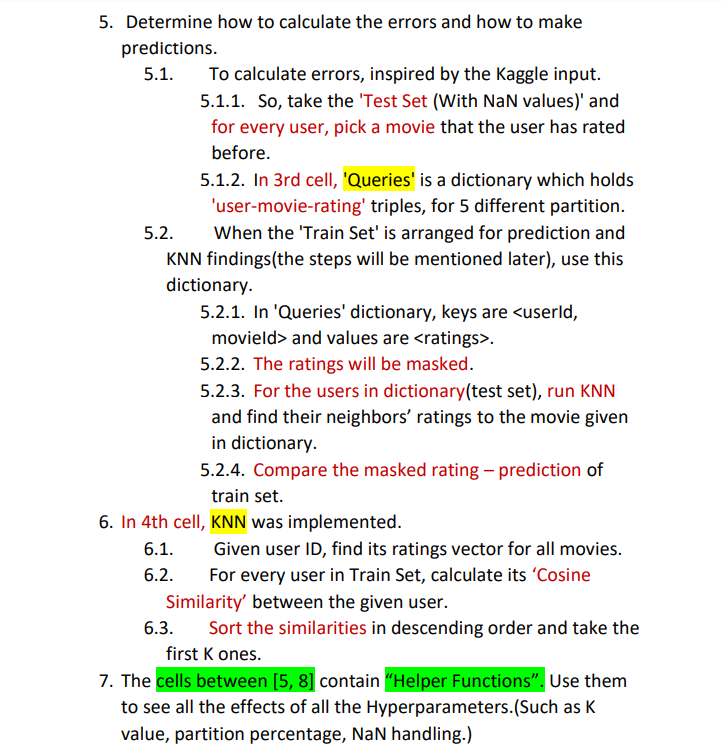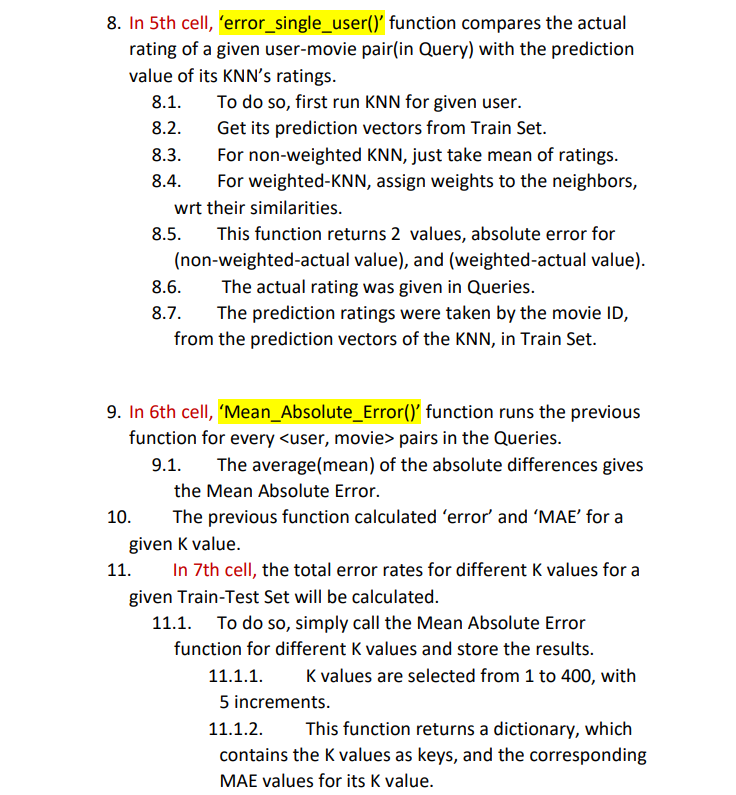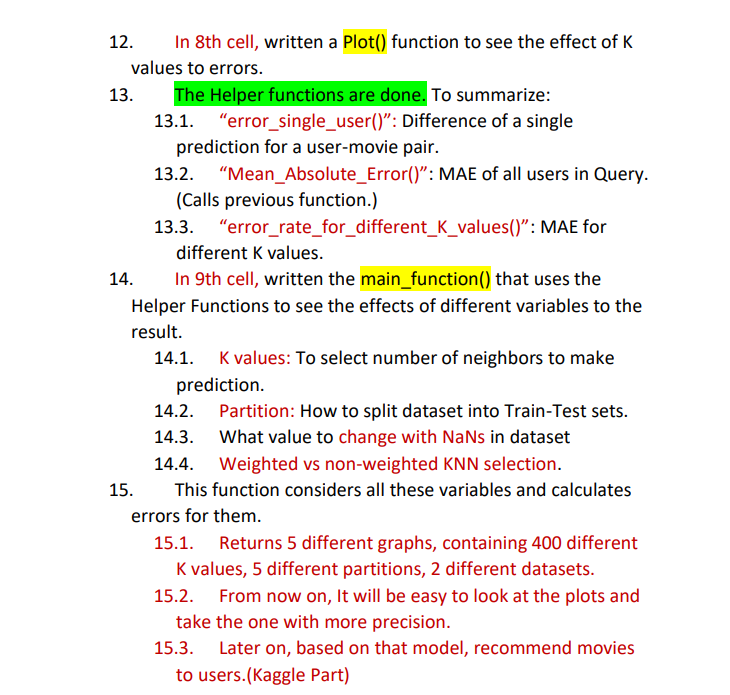


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Getting data
movies = pd.read_csv('movies.csv')
Movies = movies.drop(['genres', 'title'], axis=1) 
# genres and title are not used for rating prediction, so removed.

ratings = pd.read_csv('ratings_train.csv')
Ratings = ratings.drop(['timestamp'], axis=1) 
# timestamp is insignificant for our case, so removed.

# MOVIES AND RATINGS ARE TRANSFORMED INTO ONE DATAFRAME.
Ratings_Dataset = pd.merge(Movies, Ratings)

# THE COLUMNS AND ROWS OF THE DATAFRAME ARE ARRANGED.
Ratings = Ratings_Dataset.pivot_table(index=['userId'], columns=['movieId'], values='rating')
Ratings

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,4.0,5.0,3.0,5.0,4.0,4.0,3.0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,4.0,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
# THE DATASET SHOULD BE SPLITTED INTO TRAINING AND TEST SETS.
# THIS MAKES THE ERROR RATES MORE REALISTIC SINCE THE TEST DATA CAN NOT SEE THE OPTIMIZATIONS IN THE TRAIN DATA.
# THE USERS IN TEST DATA DO NOT APPEAR IN TRAIN DATA.

def split(ratings): 
    splitted_datasets = dict()  # There are 5 different Train-test pairs.(For different KFold values.)
    split_factors = [10, 30, 50] # Test size are taken = %10, 20, ... 50 of data.
    no_of_users = ratings.shape[0] 
    
    ratings_shuffled = ratings.sample(frac=1) # SHUFFLE THE MOVIE ORDER TO PREVENT NOISE IN DATA.

    for K in split_factors: # KFold-likely method.
        k = 100 / K 
        nTest= int(no_of_users // k) # NUMBER OF TEST SAMPLES
        nTrain = int(no_of_users - nTest) # NUMBER OF TRAIN SAMPLES
        
        train, test = ratings_shuffled[:nTrain], ratings_shuffled[nTrain: no_of_users] # slice.
        
        train = train.apply(lambda col: col.fillna(col.mean()), axis=1).T # Handle nan values with user average.
        test= test.T
        percentages = [int(K), int(100-K)]
        splitted_datasets[percentages[0], percentages[1]] = train, test # 
    return splitted_datasets

Splitted_Datasets = split(Ratings)
Ratings_T = Ratings.T # TO MAKE MATRIX OPERATIONS MORE READABLE, ROWS AND COLUMNS ARE CHANGED.
Ratings_Avg = Ratings_T.apply(lambda col: col.fillna(col.mean()), axis=1) # CHANGE THE NAN VALUES WITH THE USER AVG RATINGS.
Ratings_0 = Ratings_T.apply(lambda col: col.fillna(0), axis=1) # CHANGE THE NAN VALUES WITH THE USER AVG RATINGS.




In [3]:
# For each user in the test set, a random movie (which is rated) is selected.
# These user-movie-rating pairs will be randomly masked, just like the Kaggle inputs.
# In prediction and error calculation, these user-movie pairs will be used and the error will be the MAE.


########################## IMPORTANT NOTE ############################

# IN THIS STEP, INFINITE LOOP CAN OCCUR BECAUSE IN THE PREVIOUS STEP, THE DATASAET WAS SHUFFLED.
# SINCE THE SHUFFLING IS RANDOM, THERE CAN BE A USER WITH ALL-NAN RATINGS AND THE WHILE LOOP WILL BE INFINITE.

# IF EXECUTION TAKES MORE THAN 10 SECONDS, PLEASE RE-RUN THE PREVIOUS (SPLITTING) STEP, (2, 3.CELLS).

Queries = dict()

import random
import math

keys = list(Splitted_Datasets.keys())
for key in keys:
    query = dict() # dict structure = {[user, movie]: rating}

    Test = Splitted_Datasets[key][1]
    movies = Test.T.columns.values # All Movie IDs.
    for user in Test: # Every single user
        movie = random.choice(movies) # Select a random movie
        rate = Test[user][movie] # rating of the user-movie pair.

        while math.isnan(rate):  # until finding a non-NaN value.

            movie = random.choice(movies)
            rate = Test[user][movie]

        query[user, movie] = rate # rating found, put it in the dict.

    Queries[key] = query # This is to see if the query is collected correctly.
          # Keys: (userId, movieId), values: ratings in the TEST data.
    
# The values of this dictionary will be the masked ones.
# In prediction, the predictions -obtained from the KNN users in Train data- will be compared with the values of dict. 

In [4]:
import operator

# SIMILARITY FUNCTION HELPS FINDING THE NEAREST NEIGHBORS.
def cos_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

# Returns the K nearest neighbors of 'userId' as ID-SIMILARITY pairs.
def KNN(userId, train, K, ratings): # ratings: training set. userId: pivot user.
    len2 = train.shape[0] # movie size

    similarities = dict() # structure: {user2: cos_sim(userId, user2)}
    
    v1 = ratings[userId].values.reshape(1, len2) # rating vector of the given user.
    
    for u in train: # u = all users in train data
        v2 = train[u].values.reshape(1, len2).T # rating vector of u
        similarities[u] = cos_similarity(v1, v2).sum() # similarity between given user-u
        
    similarities = sorted(similarities.items(), key=operator.itemgetter(1), reverse=True)
    # sort similaraities by values and take the first K users.
    
    
    return similarities[0:K]

In [5]:
# Error rate for a single prediction for a user-movie pair.

def error_single_user(userId, movieId, rate, K, training, ratings):
    
    knn = KNN(userId, training, K, ratings) # Get K N N
    
    noOfMovies = training.shape[0]
    
    prediction_nw = 0 # rating prediction for non-weighted KNN
    prediction_w = 0  # rating prediction for weighted KNN
    
    total_weight = 0  # will be used in calculation of prediction_w
    
    for user in knn:
        
        # Since the similarities differ in the 5. digit after comma, weight doesn't take the first 5 digits after comma.
        weight = (10000000*user[1]) % 10000 # Weight setting. The similarities differ in the 5. digit after comma.
        total_weight += weight
        prediction_w += weight * training[user[0]][movieId]
        
        prediction_nw += training[user[0]][movieId]
        
    prediction_nw /= K # the prediction is incremented K times in loop. Divide by K to take average.
    prediction_w /= total_weight # Divide by total weight to take weighted average.
    
    return abs(rate - prediction_nw), abs(rate - prediction_w) # weighted-non weighted error pairs.

In [6]:
# MAE of all users for given K.
def Mean_Absolute_Error(query, K, training, ratings):
    error = 0 # total MAE for non-weighted knn
    error_w = 0 # total MAE for weighted knn
    
    for (user, movie) in query.keys():
        rate = query[user, int(movie)]
        en, ew = error_single_user(int(user), int(movie), rate, K, training, ratings)
        error += en
        error_w+= ew
        
    size = len(query)
    # Take mean of errors by dividing by query length.
    # Query length = number of users in test data.
    error /= size
    error_w /= size
    
    return error, error_w

In [7]:
def error_rate_for_different_K_values(query, training, ratings):
    error_wrt_K = dict() # error for different k values, non-weighted
    error_wrt_K_W = dict() # error for different k values, weighted.
    KValues = range(1, 400, 5) 
    for K in KValues:
        MAE_K, MAE_K_W = Mean_Absolute_Error(query, K, training, ratings)
        error_wrt_K[K] = MAE_K
        error_wrt_K_W[K] = MAE_K_W
    return error_wrt_K, error_wrt_K_W

In [27]:
def Plot(K_error, K_error_w):
    K = list(K_error.keys())
    err = list(K_error.values())
    err_w = list(K_error_w.values())
    plt.plot(K, err, color='red', label="non-weighted KNN", linestyle='-.')
    plt.plot(K, err_w, color='blue', label="Weighted KNN", linestyle='-.')
    plt.legend()
    plt.xlabel('K Values')
    plt.ylabel('Error Rate (Range 0-5)')
    plt.suptitle('Error Rates for KNN')
    plt.xticks(np.arange(min(K)-1, max(K)+25, 25))

    errmin = np.min(err)
    kn = -1
    for key, val in K_error.items():    # for name, age in dictionary.iteritems():  (for Python 2.x)
        if val == errmin:
            kn = key
    print("Non-weighted\nBest K = {0}\nError for K={1}: {2}\n\n".format(kn, kn, errmin))
    
    errminw = np.min(err_w)
    kw = -1
    
    for key, val in K_error_w.items():    # for name, age in dictionary.iteritems():  (for Python 2.x)
        if val == errminw:
            kw = key
    print("Weighted\nBest K = {0}\nError for K={1}: {2}".format(kw, kw, errminw))

    plt.show()
    print(kn)
    return kn, kw
    


Fold:  (10, 90)
Fold Completed  (10, 90)
Fold:  (30, 70)
Fold Completed  (30, 70)
Fold:  (50, 50)
Fold Completed  (50, 50)
Non-weighted
Best K = 6
Error for K=6: 0.8131066573163682


Weighted
Best K = 6
Error for K=6: 0.7710888405007623


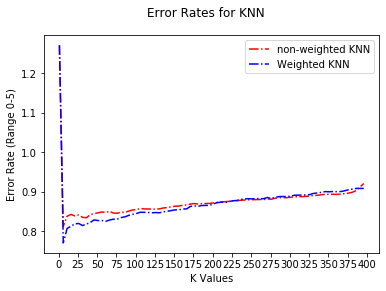

Test: 10%
Train: 90%.




Non-weighted
Best K = 11
Error for K=11: 0.767151970289586


Weighted
Best K = 11
Error for K=11: 0.7590716569166085


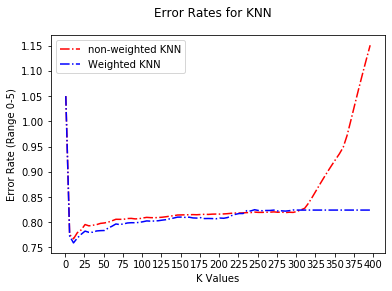

Test: 30%
Train: 70%.




Non-weighted
Best K = 41
Error for K=41: 0.7553703669595774


Weighted
Best K = 81
Error for K=81: 0.7590937949387652


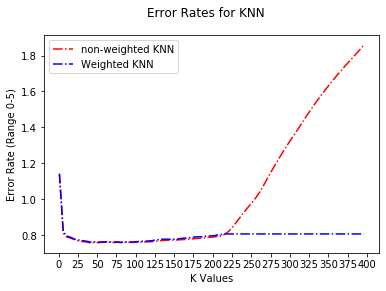

Test: 50%
Train: 50%.






In [9]:
# THIS IS THE FUNCTION THAT CALCULATES EVERY SINGLE ERROR RATE FOR THE DATASET.
# 1.) 5 DIFFERENT KFOLD VALUES HAVE BEEN TRIED.
# 2.) K VALUES BETWEEN [1,400] HAVE BEEN TRIED.
# 3.) NON-WEIGHTED AND WEIGHTED KNN HAVE BEEN TRIED.



                                    ##### IMPORTANT NOTE #####

# THIS EXECUTION TAKES 15-20 MINUTES IN MY PC BECAUSE THERE ARE 5 different Test and Train sets, 400 K VALUES
# HENCE, I EXECUTED THIS TWICE IN MY PC AND TOOK THE PICTURES OF THE OUTPUTS.
# THE BEST SPLIT RATE WAS TRAIN= %80,  TEST= %20.
# THE OUTPUTS WILL BE ON MY REPORT, SO I COMMENTED THIS FUNCTION'S CALL.
# FOR FAST EXECUTION, I ONLY TOOK THE BEST MODEL.
# THE NEXT PLOTTING WILL CONSIDER THE BEST MODEL.

def main_function(queries, splitted_datasets, ratings):
    KFold_Errors_non_weighted = dict()
    KFold_Errors_weighted = dict()
    for fold in queries:
        
        print("Fold: ", fold)
        query = queries[fold]
        Training, test= splitted_datasets[fold]
        err_nw, err_w = error_rate_for_different_K_values(query, Training, ratings)
        print("Fold Completed ", fold)
        KFold_Errors_non_weighted[fold] = err_nw
        KFold_Errors_weighted[fold] = err_w
        
    return KFold_Errors_non_weighted, KFold_Errors_weighted


# NW, W = main_function (Queries, Splitted_Datasets, Ratings_Avg) # NW = non-weighted, W = weighted errors.
# for key in Queries:
#     err = NW[key]
#     err_w = W[key]
#     Plot(err, err_w)
#     print("Test: {}%\nTrain: {}%.\n\n\n\n".format(key[0], key[1]))


# If you want to see how this works, you can simply run the commented lines.


% 10 Test, %90 Train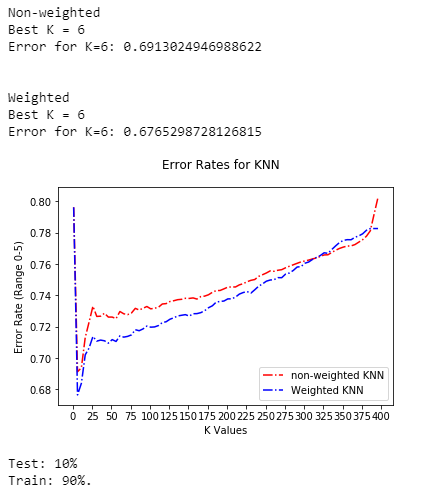
% 20 Test, %80 Train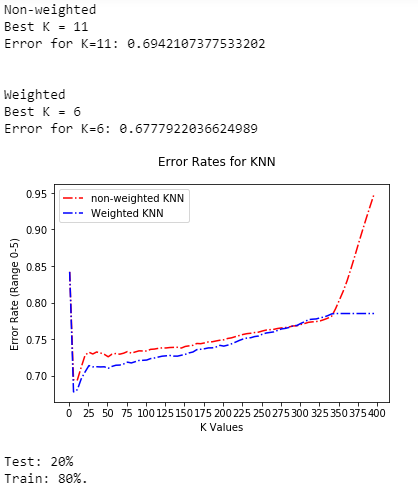
% 30 Test, %70 Train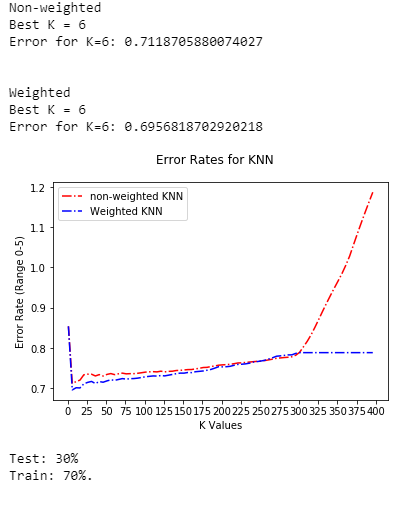
% 40 Test, %60 Train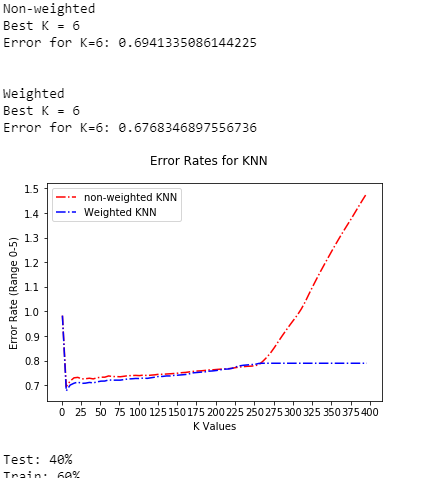
% 50 Test, %50 Train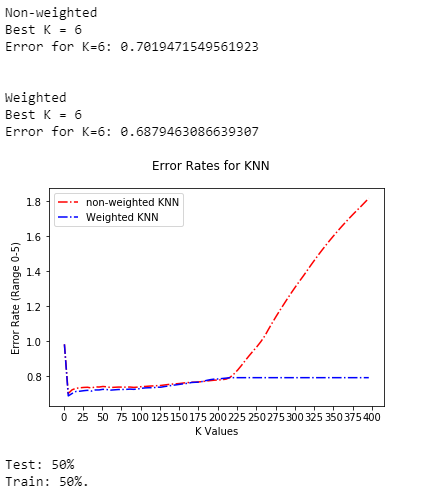

## The lowest and precise errors were obtained when the dataset was partitioned by:
### Test: %20
### Train: %80.
## So, only that model will be used for speed.

In [10]:
ratings_shuffled = Ratings.sample(frac=1)
#BEST PARTITIONING FOUND. (TEST = 20 %, TRAIN = 80 %)


In [11]:
no_of_users = Ratings.shape[0]
nTest = int(no_of_users // 5) # NUMBER OF TEST SAMPLES
nTrain = int(no_of_users - nTest) # NUMBER OF TRAIN SAMPLES

train, test = ratings_shuffled[:nTrain], ratings_shuffled[nTrain: no_of_users] # DATAFRAME SLICE

Train_Avg = train.apply(lambda col: col.fillna(col.mean()), axis=1).T # TAKE AVERAGE RATINGS FOR NANS IN TRAINS
test = test.T

In [12]:
query2 = dict() # dict structure = {[user, movie]: rating}
movies = test.T.columns.values # All Movie IDs.
for user in test: # Every single user
    movie = random.choice(movies) # Select a random movie
    rate = test[user][movie] # rating of the user-movie pair.

    while math.isnan(rate):  # until finding a non-NaN value.

        movie = random.choice(movies)
        rate = test[user][movie]

    query2[user, movie] = rate # rating found, put it in the dict.
        


Non-weighted
Best K = 11
Error for K=11: 0.7076006271014166


Weighted
Best K = 11
Error for K=11: 0.7072176819246291


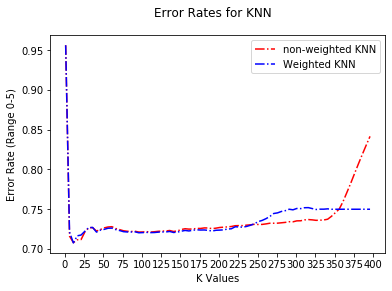

In [13]:
Kerror, Kerror_w = error_rate_for_different_K_values(query2, Train_Avg, Ratings_Avg)


# THIS IS THE CELL, WHERE THE MAIN FUNCTION CALLS ALL THE HELPER FUNCTIONS
# FOR ALL K-VALUES, FOR ALL TEST USERS, FOR ALL MOVIES..

# EXECUTION OF THIS STEP TOOK 3-4 MINUTES IN MY COMPUTER.

Non-weighted
Best K = 11
Error for K=11: 0.7076006271014166


Weighted
Best K = 11
Error for K=11: 0.7072176819246291


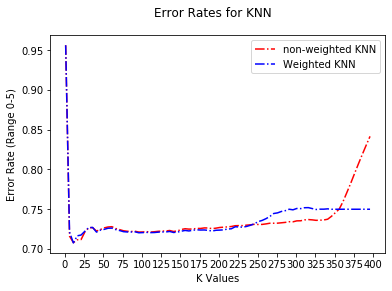

11


In [28]:
kn, kw = Plot(Kerror, Kerror_w)


### Graph Analysis: Blue Lines are generally under Red Lines. This is because in weighted KNN, far neighbors are effecting the result fewer. 
### At the end of the x-axis, it can be seen that farthest neighbors increased the error in non-weighted approach.
### Because they have the same effect as the nearest neighbors. This decreases the success of prediction


### Before finishing the model, let's test it for some users in Test Set.
### Pick random 10 users from query and compare the predictions with real ratings.

In [30]:
users = list(query.keys())
print("Original Rate\tError for Weighted KNN\tError for non-weighted KNN")
for i in range(10):
    user, movie = random.choice(users)
    rate = query[user, movie]
    err, errw = error_single_user(user, movie, rate, kn, Train_Avg, Ratings_Avg)
    print("{}\t\t{:.2f}\t\t\t{:.2f}".format(rate,float(err), float(errw) ))
    

Original Rate	Error for Weighted KNN	Error for non-weighted KNN
5.0		1.37			1.33
3.0		0.31			0.32
5.0		1.63			1.60
3.0		0.31			0.32
3.5		0.19			0.10
3.0		0.33			0.32
5.0		0.57			0.61
3.5		0.03			0.02
4.0		0.57			0.60
4.0		0.34			0.29


### ---------------------------------------------------------------------------------

### BY THIS PLOT, THE OPTIMUM MODEL IS CREATED.
### NEXT, WE CAN USE THE K VALUE AND THE PARTITIONED DATASET IN THIS PLOT TO PREDICT MOVIE RATINGS/RECOMMEND MOVIES TO USERS. THE NEXT CELLS ARE FOR THIS PURPOSE.
### BELOW CELLS ARE ALSO FOR THE KAGGLE COMPETITION.
### THE LOGIC AND THE FUNCTIONS ARE THE SAME, JUST THE PARAMETER(DATASET) OF THE FUNCTIONS WILL CHANGE
### IN ADDITION, A PROPER .CSV FILE WILL BE PREPARED.

### ---------------------------------------------------------------------------------

In [15]:
KAGGLE_dataset = pd.read_csv('ratings_test_without_gt_new.csv')

In [16]:
KAGGLE_DF= KAGGLE_dataset.pivot_table(columns=['userId'], index=['movieId'], values='rating')
KAGGLE_DF = KAGGLE_DF.apply(lambda col: col.fillna(col.mean()), axis=0)
KAGGLE_DF

userId,4,7,10,16,19,21,24,34,39,40,...,578,586,590,591,592,594,600,602,604,609
movieId,,,,,,,,,,,,,,,,,,,,,
1,3.527778,4.500000,3.264286,3.668367,4.000000,3.500000,3.609091,3.395349,3.94,5.000000,...,3.796296,4.341346,4.000000,3.166667,3.542553,3.900862,2.500000,3.362963,3.00,3.000000
2,3.527778,3.190789,3.264286,3.668367,3.000000,3.500000,3.609091,3.395349,3.94,3.708738,...,3.796296,4.000000,2.500000,3.166667,4.000000,4.000000,4.000000,4.000000,5.00,3.162162
3,3.527778,3.190789,3.264286,3.668367,3.000000,3.251693,3.609091,3.395349,3.94,3.708738,...,3.796296,4.341346,3.000000,3.166667,3.542553,4.000000,2.986894,3.362963,3.43,3.162162
4,3.527778,3.190789,3.264286,3.668367,2.598862,3.251693,3.609091,3.395349,3.94,3.708738,...,3.796296,4.341346,3.349588,3.166667,3.542553,3.900862,1.500000,3.362963,3.43,3.162162
5,3.527778,3.190789,3.264286,3.668367,2.598862,3.251693,3.609091,3.395349,3.94,3.708738,...,3.796296,4.341346,2.000000,3.166667,3.542553,3.900862,2.500000,3.362963,3.00,3.162162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188301,3.527778,3.190789,3.264286,3.668367,2.598862,3.251693,3.609091,3.395349,3.94,3.708738,...,3.796296,4.341346,3.349588,3.166667,3.542553,3.900862,2.986894,3.362963,3.43,3.162162
188675,3.527778,3.190789,3.264286,3.668367,2.598862,3.251693,3.609091,3.395349,3.94,3.708738,...,3.796296,4.341346,3.349588,3.166667,3.542553,3.900862,2.986894,3.362963,3.43,3.162162
188797,3.527778,3.190789,3.264286,3.668367,2.598862,3.251693,3.609091,3.395349,3.94,3.708738,...,3.796296,4.341346,3.349588,3.166667,3.542553,3.900862,2.986894,3.362963,3.43,3.162162


In [17]:
# Runs a KNN, takes the ratings of the k users for a specific movie, returns the rating.
def KAGGLE_KNN(userId, ratings, K):
    len2 = ratings.shape[0] #movie

    similarities = dict()
    v1 = ratings[userId].values.reshape(1, len2)

    for u in ratings:
        v2 = ratings[u].values.reshape(1, len2).T
        similarities[u] = cos_similarity(v1, v2).sum()
        
    similarities = sorted(similarities.items(), key=operator.itemgetter(1), reverse=True)    
    return similarities[1:K+1]

# Error rate for a single prediction for a user-movie pair.

def KAGGLE_predict(userId, movieId, K, ratings):
    knn = KAGGLE_KNN(userId, ratings, K) #K most similar users.
    
    no_of_movies = ratings.shape[0]
    
    prediction = np.zeros((1, no_of_movies))
    for user in knn:
        prediction += ratings[user[0]].to_numpy().reshape(1, no_of_movies)
    prediction /= K

    return prediction[0][list(ratings.T.columns).index(movieId)]

# IN KAGGLE INPUT, THE USERS WITH -1 RATINGS ARE TAKEN.
def KAGGLE_find_nans(dataset):
    return dataset[dataset['rating'] == -1]


def KAGGLE_rating_predict(dataset, ratings, output, K):
    nans = KAGGLE_find_nans(dataset)
        
    for index, row in nans.iterrows():
        user=int(row['userId'])
        movie=int(row['movieId'])
                    
        output[user] = KAGGLE_predict(user, movie, K, ratings)
    


In [18]:
out = dict()
KAGGLE_rating_predict(KAGGLE_dataset, KAGGLE_DF, out, K=37)

In [19]:
import csv
name = input("File Name:")
with open(name, 'w') as csvfile:
    count=0
    filewriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    filewriter.writerow(['Id', 'rating'])
    for key in out:
        filewriter.writerow([count, out[key]])
        count+=1


File Name:541


## In Kaggle part, kaggle input and the previous dataset is combined.
## 2nd input is used as Test case, and 1st data is used as Training set.